# DATA TRANSFORMATION

# Principal Component Analysis

## Dimensionality Reduction
## PCA Interpretation

We will need:
- sklearn
- matplotlib
- numpy
- pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
from warnings import filterwarnings 
filterwarnings('ignore')

## Theory

Any dataset represents as a matrix 𝑋. Principal Component Analysis consistently finds linear combinations of its features - "components".

A Covariance Matrix _Q_ is a square matrix giving the covariance between each pair of elements of a given random vector. In the matrix diagonal there are variances, i.e., the covariance of each element with itself.
The singular decomposition of the matrix 𝑄 is as follows:

$$Q = X^TX = W \Lambda W^T$$

The columns of the matrix 𝑊 are the main components of the matrix 𝑋. Moreover, the variance of the data along the direction given by each component is equal to the corresponding value of the diagonal matrix _Λ._

How then, on the basis of this transformation, can we reduce the dimension? We can rank the components using the variance of the data along them:

$$ \Lambda_1 > \Lambda_2 > ... \Lambda_D $$

Then, if we select the components corresponding to the first _d_ variances from this list, we get a set of _d_ new features that best describes the variance of the initial dataset among all other possible linear combinations of the original features of the matrix 𝑋. It turns out that the PCA allows us to rank the obtained components by "significance", as well as starts the process of their selection.


The data for this example were generated in accordance with the proposed PCA model. That is: data 𝑌 with effective dimension _d_, obtained from independent uniform distributions, is linearly transformed by a random matrix 𝑊 into a space of dimension 𝐷, after which independent normal noise was added to all the features.

## 1. Automatic dimensional data reduction using the likelihood logarithm

Consider a dataset of dimension 𝐷 whose real dimension _d_ is much smaller than the observed. What we will do is:
 - For each value of 𝑑̂ in the interval [1, D], construct a PCA model with 𝑑̂ main components;
 - Estimate average logarithm likelihood data for each model in the population using the cross-validation with 3 folds;
 - Find the model with maximum logarithm, i.e. best model for data description.

In [3]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score as cv_score

data = pd.read_csv('data_task1.csv')    

In [4]:
d_scores = np.zeros((data.shape[1],2))  # matrix contains number of components and score 
for d in range(1,data.shape[1]+1):
    model = PCA(n_components=d)
    model.fit(data)
    scores = cv_score(model, data, cv = 3)
    d_scores[d-1,0] = d
    d_scores[d-1,1] = scores.mean()

In [5]:
# Visualization

def plot_scores(d_scores):
    n_components = d_scores[:,0]
    plt.plot(n_components, d_scores[:,1], 'b', label='PCA scores')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('cv scores')
    plt.legend(loc='lower right')
    plt.show()

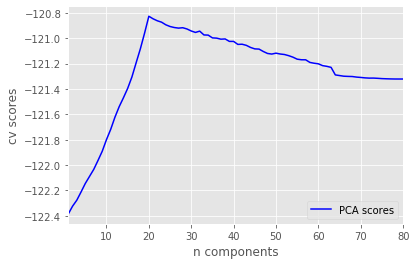

In [6]:
plot_scores(d_scores)

In [7]:
Log = (d_scores[:,1]).max()
ind = np.where(d_scores[:,1] == Log )
print('optimum d:', d_scores[:,0][ind])

optimum d: [20.]


## 2. Manual reduction of feature dimension by analyzing data variance along principal components

As we remember, we can reduce the dimension of the data by dropping _q_ of the final principal components having the smallest variance if we sort them in descending order. There are two different ways to do this. A more general way of selecting features is that we can look at the differences in variances in the sorted series: $\lambda_{(1)}-\lambda_{(2)}, \dots, \lambda_{(D-1)} - \lambda_{(D)}$ and remove those components on which the difference will be the largest.

In [8]:
data = pd.read_csv('data_task2.csv')

In [9]:
# Build model with D principal components
model = PCA()      # n_components == min(n_samples, n_features) = n_features
model.fit(data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
# components in descending order
model.components_

# variance in descending order 
Lambda = model.explained_variance_
X = model.transform(data)   # projection on D components

# Variance on transform data
Var = np.var(X, axis=0)

In [11]:
# Shift variance function

def shift(array_1D):
    z = np.zeros(array_1D.shape[0]-1)
    for i in range(array_1D.shape[0]-1):
        z[i] = array_1D[i]-array_1D[i+1]
    return z   

In [12]:
d_var = shift(Var)

In [13]:
# Visualization

def plot_variances(d_variances):
    n_components = np.arange(1,d_variances.size+1)
    plt.plot(n_components, d_variances, 'b', label='Component variances')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('variance')
    plt.legend(loc='upper right')
    plt.show()
    print('optimum d:', n_components[d_var.argmax()])

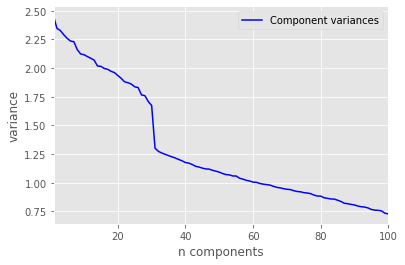

optimum d: 30


In [14]:
plot_variances(Var)

## 3. Principal components interpretation

As the principal components, we get linear combinations of the original features, so the question of their interpretation is reasonable.

There are several approaches, but we will look at two:
- calculate the relationship of the principal components with the initial features
- calculate the contributions of each particular observation to the principal components

The first method is suitable in case all the objects from the dataset do not carry any semantic information for us that is no longer captured in the set of features.

The second method is suitable for the case in which the data has a more complex structure. For example, faces of a person carry more semantic meaning than the vector of pixel values that PCA analyzes.

### 3.1. Analysis of the principal components using correlations with the initial features.

This method consists in calculating the correlation coefficients between the initial features and the set of principal components. Since the principal component analysis is linear, it is proposed to use the Pearson correlation.

For this we will use _iris_ dataset that consists of 4 features, calculated for 150 irises. Each of them belongs to one of three species.

In [15]:
# Load data

from sklearn import datasets
iris = datasets.load_iris()
data = iris.data
target = iris.target
target_names = iris.target_names

In [16]:
# Build a model with default principal components

model = PCA()   # n_components = 4
model.fit(data)
X = model.transform(data)   # projection on components

Let's calculate the correlations of the original features with their projections on the first two principal components.

In [17]:
w = model.components_
print('1st component: ', w[0])
print('2nd component: ', w[1])

1st component:  [ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
2nd component:  [ 0.65658877  0.73016143 -0.17337266 -0.07548102]


In [18]:
from scipy import stats

corr = np.zeros((2,4))
for i in range(2):
    for j in range(4):
        corr[i,j]= stats.pearsonr(data[:,j], X[:,i])[0] 
print('Correlation between 4 features and their first 2 projections:\n', corr)

Correlation between 4 features and their first 2 projections:
 [[ 0.89740176 -0.39874847  0.99787394  0.96654752]
 [ 0.39060441  0.82522871 -0.0483806  -0.0487816 ]]


In [19]:
# Group features by components with which it correlates most

corr_pca = abs(corr).argmax(axis = 0)
pca1 = np.where(corr_pca == 0)[0] +1
pca2 = np.where(corr_pca == 1)[0] +1
print('PCA 1 Corr: ', pca1)
print('PCA 2 Corr: ', pca2)

PCA 1 Corr:  [1 3 4]
PCA 2 Corr:  [2]


In [20]:
# Representation with 2 components

def plot_iris(transformed_data, target, target_names):
    plt.figure()
    for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
        plt.scatter(transformed_data[target == i, 0],
                    transformed_data[target == i, 1], c=c, label=target_name)
    plt.xlabel('1 PCA')
    plt.ylabel('2 PCA')
    plt.legend()
    plt.show()

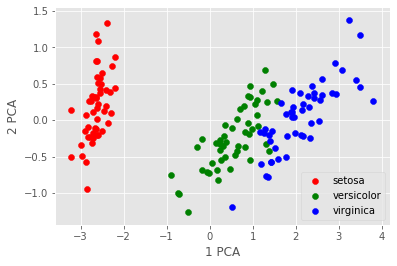

In [21]:
plot_iris(X, target, target_names)

### 3.2. Analysis of the principal components using contributions to their dispersion of individual objects

Now consider a value that can be interpreted as the square of the cosine of the angle between the sample object and the principal component:

$$ cos^2_{ik} = \frac{f_{ik}^2}{\sum_{\ell=1}^d f_{i\ell}^2} $$

where:
- i -- object number
- k -- principal component number
- $f_{ik}$ -- the module of projection of the object on the component

Obviously,

$$ \sum_{k=1}^d cos^2_{ik} = 1 $$

This means that for each object we got weights proportional to its contribution to the dispersion of each component. As we remember, cos(0º) = 1. In other words, the higher this value, the higher the object matches the principal component.

We will use the _Olivetti Faces_ face dataset and train it on the Randomized PCA model that is used for a large number of features and works faster than a regular PCA.

In [22]:
# Data load

from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

data = fetch_olivetti_faces(shuffle=True, random_state=0).data
image_shape = (64, 64)

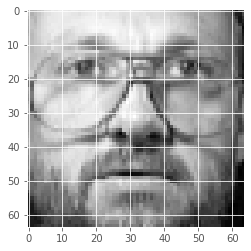

In [23]:
plt.imshow(data[0].reshape(image_shape), cmap='gray')  #, interpolation='nearest')

In [24]:
data.shape

(400, 4096)

In [25]:
# Training Randomized PCA with 10 components

model = PCA(svd_solver = 'randomized', n_components = 10)
model.fit(data)
X = model.transform(data)  # projection of data on 10 components

In [26]:
# 10 principal components
w = model.components_

In [27]:
# Relative contribution for each object to the variance of each components

X2 = X**2
suma = (X2).sum(axis = 1)
cos2 = np.zeros((X.shape))
for i in range(X.shape[0]):
    cos2[i,:] = X2[i,:]/ suma[i]
cos2.shape   

(400, 10)

For each component, we find and visualize the face that makes the most contribution to it.

In [28]:
ind_obj = cos2.argmax(axis = 0)
faces = data[ind_obj]
print('Objects with more contribution\n', ind_obj)

Objects with more contribution
 [197  18  66 319 363 131 142 382 353 140]


Populating the interactive namespace from numpy and matplotlib


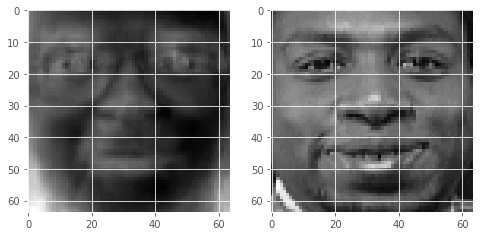

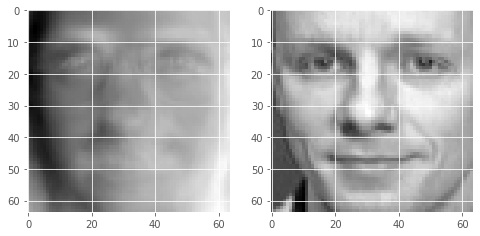

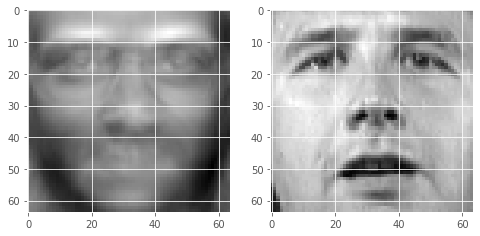

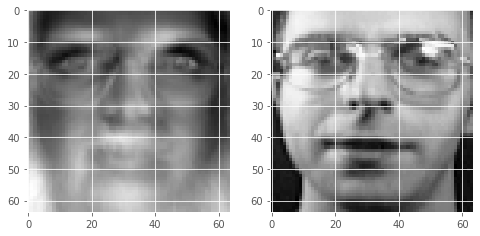

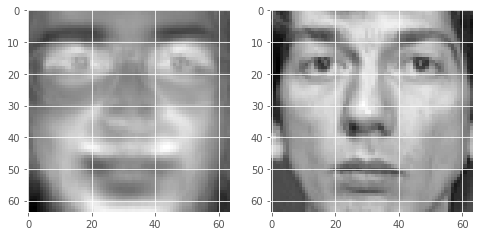

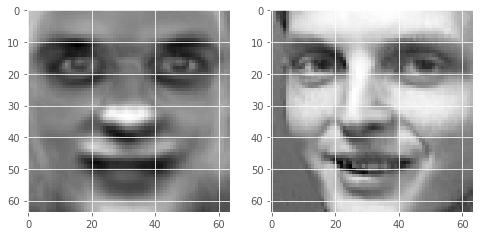

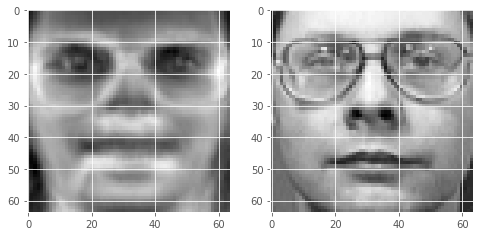

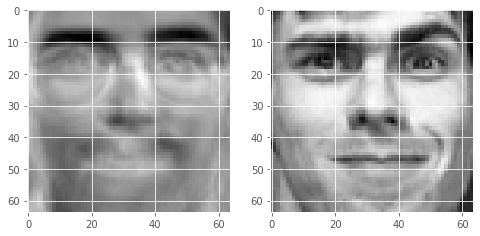

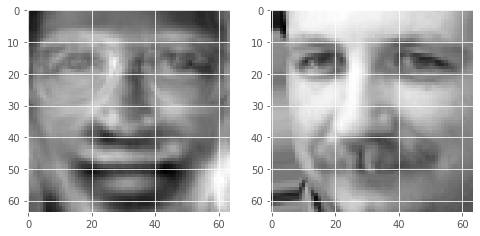

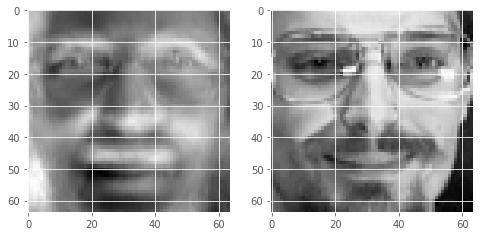

In [29]:
%pylab inline
for i in range(10):
    pylab.figure(figsize(8, 8))
    pylab.subplot(1,2,1)
    pylab.imshow(w[i].reshape(image_shape), cmap='gray')
    pylab.subplot(1,2,2)
    pylab.imshow(faces[i].reshape(image_shape), cmap='gray')
    pylab.show()